# Импорты

Импорт всех необходимых библиотек

In [99]:
%pip install -q catboost
%pip install -q optuna


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [100]:
%pip install -q shap


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRFClassifier
from sklearn.model_selection import cross_validate, cross_val_score
from shap import TreeExplainer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


In [102]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer

In [103]:
import optuna
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from optuna.samplers import RandomSampler, TPESampler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from lightgbm import LGBMClassifier
import catboost

In [104]:
import warnings
warnings.filterwarnings("ignore")

Импорт датасета

In [105]:
df = pd.read_csv('db_subset.csv')
df

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
0,NaN,NaN,NaN,NaN,0.04,11.03,21.41,128.17,495.78,0.72,0.04,0.93,NaN,NaN,0.75,0.08,378.50,NaN,NaN,0.32,19.83,2.25,NaN,NaN,NaN,28.18,0.04,26.83,NaN,8.00,0.06,0.05,0.03,0.04,49.00,NaN,NaN,NaN,NaN,NaN,33.75,0.02,NaN,NaN,0.72,0.06,NaN,NaN,50.00,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,0.66,0.11,NaN,NaN,0.21,NaN,NaN,0.17,0,0,0,0,NaN,0
1,NaN,NaN,NaN,NaN,0.02,10.72,12.43,77.82,727.72,0.37,0.02,0.66,NaN,NaN,0.64,0.05,324.95,NaN,NaN,0.19,15.86,0.94,NaN,NaN,NaN,17.79,0.02,23.26,NaN,4.80,0.04,0.06,0.05,0.02,45.40,NaN,NaN,NaN,NaN,NaN,26.08,0.01,NaN,NaN,0.48,0.04,NaN,NaN,30.00,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN,1.12,0.11,NaN,NaN,0.24,NaN,NaN,0.15,0,0,0,0,NaN,0
2,NaN,NaN,NaN,NaN,0.04,25.63,19.99,147.13,373.79,0.93,0.04,1.11,NaN,NaN,1.00,0.08,354.73,NaN,NaN,0.34,25.80,4.77,NaN,NaN,NaN,28.46,0.04,29.70,NaN,8.83,0.07,0.03,0.02,0.05,37.83,NaN,NaN,NaN,NaN,NaN,35.00,0.02,NaN,NaN,0.73,0.06,NaN,NaN,53.22,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.69,NaN,NaN,NaN,0.11,0.10,NaN,NaN,0.32,NaN,NaN,0.26,1,0,0,0,NaN,0
3,NaN,NaN,NaN,0.53,0.06,4.42,NaN,2.27,0.42,NaN,0.03,0.14,0.01,0.01,0.02,0.01,2.45,NaN,0.01,0.22,0.12,NaN,NaN,NaN,0.01,NaN,0.02,0.19,NaN,0.02,0.00,0.00,0.00,0.00,0.02,0.01,0.43,NaN,NaN,0.01,1.45,0.00,NaN,0.00,0.02,0.01,NaN,0.01,NaN,0.01,0.00,0.00,0.00,NaN,0.01,NaN,NaN,0.01,0.04,NaN,0.01,NaN,0.00,0.00,NaN,NaN,0.17,NaN,NaN,0.03,0,0,0,0,NaN,0
4,NaN,NaN,NaN,1.08,0.05,1.34,NaN,2.94,1.04,NaN,0.05,0.33,0.03,0.02,0.02,0.00,5.97,NaN,0.02,0.10,0.20,NaN,NaN,NaN,0.02,NaN,0.05,0.40,NaN,0.09,0.00,0.00,0.00,0.00,0.10,0.03,0.82,NaN,NaN,0.04,3.32,0.00,NaN,0.01,0.05,0.00,NaN,0.02,NaN,0.02,NaN,0.01,0.00,NaN,0.02,NaN,NaN,0.03,0.07,NaN,0.02,0.01,0.00,0.00,NaN,NaN,0.26,NaN,NaN,0.08,0,0,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,30.2,67.3,42.4,477.17,24.50,1797.91,82.62,1354.90,1223.05,12.31,10.50,55.08,1.96,1.71,11.42,5.57,2305.47,17.34,0.88,56.86,760.68,2.33,0.60,15.07,1.44,163.39,9.33,217.28,8.92,466.08,1.00,1.51,2.84,0.95,218.19,3.14,182.73,62.20,0.02,2.45,961.52,0.84,0.02,0.81,11.14,4.89,0.01,1.30,109.94,1.30,1.29,0.38,3.59,60.64,1.41,0.88,6.67,2.51,10.56,181.60,113.14,4.17,4.55,0.73,9.21,24.18,60.15,68.55,6.56,4.58,1,0,0,1,35.986159,0
2881,36.1,77.1,51.6,1867.95,34.70,3373.56,81.50,2929.34,3550.36,20.59,32.17,185.21,11.50,9.37,27.31,23.95,5804.66,45.02,5.17,104.79,1344.17,8.78,0.25,31.35,8.34,270.83,28.52,534.18,7.92,5607.64,2.03,3.12,10.60,3.72,589.55,30.73,406.35,1249.62,0.33,14.14,2606.66,5.33,0.10,4.66,35.63,13.19,0.02,7.10,295.28,7.91,2.22,1.99,12.16,142.43,7.68,2.35,48.00,13.78,35.43,330.24,372.68,6.19,9.96,2.34,8.96,16.95,254.15,179.18,6.91,24.05,1,0,0,1,59.519091,1
2882,19.9,47.5,27.9,356.44,33.42,3321.43,115.59,2744.22,2027.59,34.25,17.10,103.58,5.77,4.63,26.87,42.02,5027.29,36.82,2.78,134.74,875.24,28.08,3.20,116.85,4.18,252.72,14.96,500.51,26.21,1060.56,2.15,2.15,6.73,3.05,417.65,6.31,185.98,141.09,0.33,7.05,1565.

<Axes: ylabel='Count'>

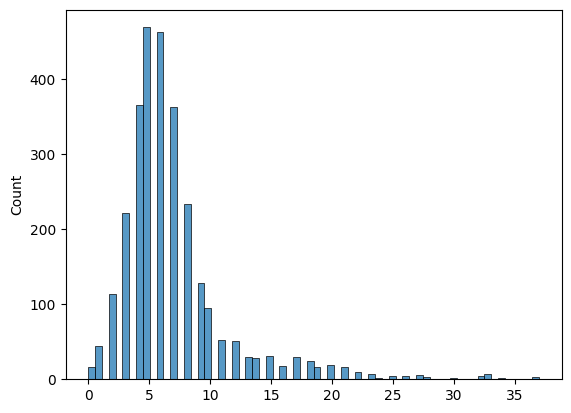

In [106]:
missing_features = df.isnull().sum(axis=1)
sns.histplot(missing_features)

# Предобработка датасета

Все признаки имеют числовой вид, посмотрим на распределение классов

In [107]:
df = df.drop(df[df['bmi']>80].index)

In [108]:
df.loc[df['target'] == 0]['target'].count(), df.loc[df['target'] == 1]['target'].count()

(1871, 1011)

<Axes: xlabel='target', ylabel='Count'>

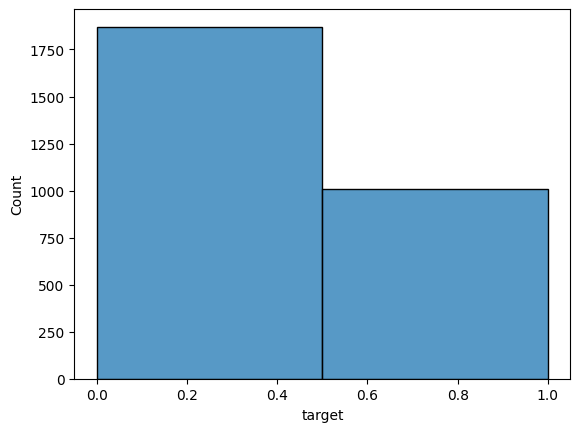

In [109]:
sns.histplot(df['target'], bins = 2)

Классы находятся в соотношении 2:1, будем считать, что они сбалансированы.

Теперь посмотрим на признаки объектов:

In [110]:
df.columns, len(df.columns)

(Index(['внутриклеточная_жидкость', 'тощая_мт', 'акм', 'холестерин', 'нас._жир',
        'натрий_na', 'сахара', 'энергия', 'вода', 'пищ._волокна',
        'мононенас._жир', 'белки', 'аргинин', 'валин', 'зола', 'полиненас._жир',
        'калий_k', 'крахмал', 'гистидин', 'жиры', 'кальций_ca', 'алкоголь',
        'кремний_si', 'сера_s', 'изолейцин', 'углеводы', 'олеиновая_кислота',
        'магний_mg', 'фруктоза', 'a', 'b1_тиамин', 'b2_рибофлав.',
        'b5_пантотен._кис.', 'b6_пиридоксин', 'b9_фолаты', 'b12_кобаламин',
        'b4_холин', 'β-каротин', 'ретин._эквив.', 'лейцин', 'фосфор_p',
        'омега-3', 'лактоза', 'метионин', 'железо_fe', 'омега-6', 'галактоза',
        'метионин+цистеин', 'c', 'треонин', 'd', 'триптофан', 'e_α-токоферол',
        'гамма-линолен._к-та', 'фенилаланин', 'h_биотин', 'бор_b',
        'фенилаланин+тирозин', 'pp_ниацин', 'ванадий_v', 'йод_i', 'кобальт_co',
        'марганец_mn', 'медь_cu', 'молибден_mo', 'никель_ni', 'селен_se',
        'фтор_f', 'хром_

Поделим датасет на тренировочную и тестовую выборки, отнормируем их, а затем уже попробуем выбрать наиболее значимые признаки.

<Axes: xlabel='bmi', ylabel='Count'>

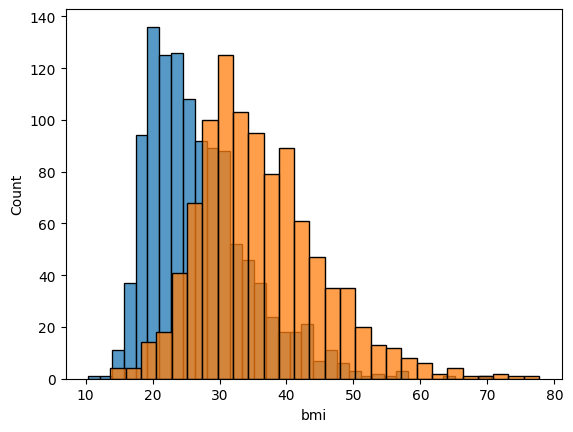

In [111]:
sns.histplot(df[df['target']==0]['bmi'], legend=True)
sns.histplot(df[df['target']==1]['bmi'], legend=True)

In [112]:
df_test = pd.concat([df[df['bmi']<35][df['bmi']>25][df['target']==0].sample(n=216),
                    df[df['bmi']<35][df['bmi']>25][df['target']==1].sample(n=216)])
df_test

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
1704,NaN,NaN,NaN,560.47,58.60,3941.72,111.30,2762.62,2295.69,27.37,27.99,108.67,4.50,4.12,26.03,16.84,4749.19,65.50,2.36,147.35,1017.36,6.44,1.60,121.72,3.48,258.69,25.32,476.49,20.66,1388.32,1.94,2.24,5.42,2.24,307.13,3.38,181.23,0.00,0.02,5.94,1765.13,1.17,0.00,1.96,24.46,11.05,0.06,3.09,149.66,3.41,1.52,0.94,13.34,NaN,3.35,9.69,100.00,6.00,24.09,12.04,92.27,22.66,3.86,1.66,33.17,78.95,109.26,176.65,24.09,11.06,1,0,1,0,26.573129,0
843,NaN,NaN,NaN,906.43,32.78,2299.30,80.75,1800.48,1984.28,20.89,16.40,131.61,6.02,4.70,22.21,11.90,4497.77,5.32,2.89,83.34,851.47,31.83,NaN,85.19,4.16,101.58,14.70,370.06,32.85,850.76,1.01,2.46,5.47,2.15,172.24,6.50,318.02,0.00,0.04,7.10,1661.04,2.02,NaN,2.34,27.74,7.88,0.00,3.55,160.31,3.98,2.04,1.08,11.86,NaN,3.85,6.42,26.67,6.98,16.75,20.00,236.91,32.57,1.99,1.80,58.17,137.40,102.61,151.21,40.83,11.42,1,0,1,0,33.574380,0
174,NaN,NaN,NaN,373.72,16.30,770.89,8.98,511.20,656.45,0.47,8.49,33.82,1.53,1.28,4.15,3.10,663.90,4.44,0.72,39.19,281.03,1.58,NaN,NaN,1.12,15.29,7.56,67.15,NaN,248.73,0.26,0.78,1.33,0.30,43.10,1.31,124.87,NaN,NaN,1.85,465.22,0.24,NaN,0.66,3.11,3.08,NaN,0.98,1.65,1.03,1.16,0.27,1.33,44.33,1.00,NaN,NaN,1.88,4.38,90.00,50.57,NaN,0.73,0.16,NaN,NaN,36.90,10.60,NaN,2.58,0,1,0,1,32.660764,0
2168,NaN,NaN,NaN,1597.13,90.50,11442.27,228.20,6047.85,2932.37,63.88,77.46,249.70,10.60,8.25,57.37,45.46,9876.00,131.96,4.54,274.56,2002.60,NaN,7.20,142.40,6.95,675.08,68.91,1075.00,30.31,1251.90,3.90,5.01,10.98,4.25,813.25,19.48,446.40,62.06,1.00,12.62,3811.80,5.00,0.15,3.66,48.95,43.28,0.27,5.81,354.94,6.55,1.31,1.97,35.86,NaN,6.80,4.56,80.00,11.85,63.52,28.80,139.00,59.68,8.27,5.36,27.00,39.60,215.81,174.57,21.00,41.36,1,0,0,1,33.659297,0
12,NaN,NaN,NaN,18.60,3.98,498.84,0.20,120.40,21.40,0.02,1.30,6.21,0.22,0.28,1.22,0.25,100.64,0.28,0.15,10.38,7.34,NaN,NaN,NaN,0.18,0.50,1.18,8.20,NaN,NaN,0.09,0.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.34,68.44,0.03,NaN,0.15,0.68,0.22,NaN,0.22,NaN,0.22,NaN,0.07,0.12,NaN,0.18,NaN,NaN,0.34,1.09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,1,29.760838,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2824,27.38,52.0,45.41,1062.49,62.04,4412.14,193.55,3690.79,2342.04,39.12,37.14,173.52,8.56,6.93,30.40,21.49,6153.15,58.63,3.96,165.70,1471.27,24.87,7.70,103.59,6.08,349.10,33.98,585.90,33.80,1256.53,2.27,3.39,9.03,3.15,406.39,6.21,467.92,39.81,0.02,10.13,2350.88,1.92,0.01,3.34,28.75,19.68,0.05,5.04,288.93,5.57,3.28,1.57,18.98,NaN,5.53,9.41,42.80,10.03,31.67,67.20,23.69,28.22,4.09,2.47,40.26,107.55,178.90,191.29,40.11,21.98,1,0,1,0,31.172840,1
914,NaN,NaN,NaN,517.26,31.55,2183.89,70.25,2431.92,2100.77,22.77,17.24,108.52,6.82,5.20,17.60,19.05,3819.39,13.38,2.76,87.65,821.63,NaN,0.15,47.09,4.68,288.03,14.84,372.47,10.59,547.05,2.24,2.09,8.31,2.66,577.59,3.14,125.75,NaN,NaN,7.64,1618.60,2.72,NaN,2.55,24.61,10.75,0.00,3.97,80.57,4.16,0.72,1.13,7.23,66.08,4.20,3.77,32.00,7.60,30.39,341.6

In [113]:
df_train = df.drop(df_test.index)
df_train

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi,target
0,NaN,NaN,NaN,NaN,0.04,11.03,21.41,128.17,495.78,0.72,0.04,0.93,NaN,NaN,0.75,0.08,378.50,NaN,NaN,0.32,19.83,2.25,NaN,NaN,NaN,28.18,0.04,26.83,NaN,8.00,0.06,0.05,0.03,0.04,49.00,NaN,NaN,NaN,NaN,NaN,33.75,0.02,NaN,NaN,0.72,0.06,NaN,NaN,50.00,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,0.66,0.11,NaN,NaN,0.21,NaN,NaN,0.17,0,0,0,0,NaN,0
1,NaN,NaN,NaN,NaN,0.02,10.72,12.43,77.82,727.72,0.37,0.02,0.66,NaN,NaN,0.64,0.05,324.95,NaN,NaN,0.19,15.86,0.94,NaN,NaN,NaN,17.79,0.02,23.26,NaN,4.80,0.04,0.06,0.05,0.02,45.40,NaN,NaN,NaN,NaN,NaN,26.08,0.01,NaN,NaN,0.48,0.04,NaN,NaN,30.00,NaN,NaN,NaN,0.05,NaN,NaN,NaN,NaN,NaN,0.50,NaN,NaN,NaN,1.12,0.11,NaN,NaN,0.24,NaN,NaN,0.15,0,0,0,0,NaN,0
2,NaN,NaN,NaN,NaN,0.04,25.63,19.99,147.13,373.79,0.93,0.04,1.11,NaN,NaN,1.00,0.08,354.73,NaN,NaN,0.34,25.80,4.77,NaN,NaN,NaN,28.46,0.04,29.70,NaN,8.83,0.07,0.03,0.02,0.05,37.83,NaN,NaN,NaN,NaN,NaN,35.00,0.02,NaN,NaN,0.73,0.06,NaN,NaN,53.22,NaN,NaN,NaN,0.08,NaN,NaN,NaN,NaN,NaN,0.69,NaN,NaN,NaN,0.11,0.10,NaN,NaN,0.32,NaN,NaN,0.26,1,0,0,0,NaN,0
3,NaN,NaN,NaN,0.53,0.06,4.42,NaN,2.27,0.42,NaN,0.03,0.14,0.01,0.01,0.02,0.01,2.45,NaN,0.01,0.22,0.12,NaN,NaN,NaN,0.01,NaN,0.02,0.19,NaN,0.02,0.00,0.00,0.00,0.00,0.02,0.01,0.43,NaN,NaN,0.01,1.45,0.00,NaN,0.00,0.02,0.01,NaN,0.01,NaN,0.01,0.00,0.00,0.00,NaN,0.01,NaN,NaN,0.01,0.04,NaN,0.01,NaN,0.00,0.00,NaN,NaN,0.17,NaN,NaN,0.03,0,0,0,0,NaN,0
4,NaN,NaN,NaN,1.08,0.05,1.34,NaN,2.94,1.04,NaN,0.05,0.33,0.03,0.02,0.02,0.00,5.97,NaN,0.02,0.10,0.20,NaN,NaN,NaN,0.02,NaN,0.05,0.40,NaN,0.09,0.00,0.00,0.00,0.00,0.10,0.03,0.82,NaN,NaN,0.04,3.32,0.00,NaN,0.01,0.05,0.00,NaN,0.02,NaN,0.02,NaN,0.01,0.00,NaN,0.02,NaN,NaN,0.03,0.07,NaN,0.02,0.01,0.00,0.00,NaN,NaN,0.26,NaN,NaN,0.08,0,0,0,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2879,18.0,43.3,22.8,148.86,13.66,1495.20,46.12,981.38,792.79,10.46,8.36,30.54,1.16,0.95,8.25,10.06,1370.94,22.00,0.55,45.36,314.95,1.57,1.20,20.88,0.82,119.19,7.66,167.39,4.63,624.41,0.67,0.72,1.72,0.66,134.80,1.20,63.84,124.40,0.02,1.42,519.06,0.77,0.01,0.41,7.36,6.29,0.01,0.72,40.34,0.82,0.32,0.23,6.67,19.18,0.85,0.82,48.00,1.45,10.10,87.20,21.02,4.78,6.31,0.52,3.88,9.44,39.28,45.79,4.36,2.92,1,0,0,1,23.335466,0
2880,30.2,67.3,42.4,477.17,24.50,1797.91,82.62,1354.90,1223.05,12.31,10.50,55.08,1.96,1.71,11.42,5.57,2305.47,17.34,0.88,56.86,760.68,2.33,0.60,15.07,1.44,163.39,9.33,217.28,8.92,466.08,1.00,1.51,2.84,0.95,218.19,3.14,182.73,62.20,0.02,2.45,961.52,0.84,0.02,0.81,11.14,4.89,0.01,1.30,109.94,1.30,1.29,0.38,3.59,60.64,1.41,0.88,6.67,2.51,10.56,181.60,113.14,4.17,4.55,0.73,9.21,24.18,60.15,68.55,6.56,4.58,1,0,0,1,35.986159,0
2881,36.1,77.1,51.6,1867.95,34.70,3373.56,81.50,2929.34,3550.36,20.59,32.17,185.21,11.50,9.37,27.31,23.95,5804.66,45.02,5.17,104.79,1344.17,8.78,0.25,31.35,8.34,270.83,28.52,534.18,7.92,5607.64,2.03,3.12,10.60,3.72,589.55,30.73,406.35,1249.62,0.33,14.14,2606.66,5.33,0.10,4.66,35.63,13

In [114]:
x_train = df_train.drop(columns=['target'])
y_train = df_train['target']

In [115]:
x_test = df_test.drop(columns=['target'])
y_test = df_test['target']

In [116]:
column_names = x_train.columns

In [117]:
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train))
x_test = pd.DataFrame(scaler.transform(x_test))

In [118]:
column_dict = {a: column_names[a] for a in range(len(x_train.columns))}
column_dict

{0: 'внутриклеточная_жидкость',
 1: 'тощая_мт',
 2: 'акм',
 3: 'холестерин',
 4: 'нас._жир',
 5: 'натрий_na',
 6: 'сахара',
 7: 'энергия',
 8: 'вода',
 9: 'пищ._волокна',
 10: 'мононенас._жир',
 11: 'белки',
 12: 'аргинин',
 13: 'валин',
 14: 'зола',
 15: 'полиненас._жир',
 16: 'калий_k',
 17: 'крахмал',
 18: 'гистидин',
 19: 'жиры',
 20: 'кальций_ca',
 21: 'алкоголь',
 22: 'кремний_si',
 23: 'сера_s',
 24: 'изолейцин',
 25: 'углеводы',
 26: 'олеиновая_кислота',
 27: 'магний_mg',
 28: 'фруктоза',
 29: 'a',
 30: 'b1_тиамин',
 31: 'b2_рибофлав.',
 32: 'b5_пантотен._кис.',
 33: 'b6_пиридоксин',
 34: 'b9_фолаты',
 35: 'b12_кобаламин',
 36: 'b4_холин',
 37: 'β-каротин',
 38: 'ретин._эквив.',
 39: 'лейцин',
 40: 'фосфор_p',
 41: 'омега-3',
 42: 'лактоза',
 43: 'метионин',
 44: 'железо_fe',
 45: 'омега-6',
 46: 'галактоза',
 47: 'метионин+цистеин',
 48: 'c',
 49: 'треонин',
 50: 'd',
 51: 'триптофан',
 52: 'e_α-токоферол',
 53: 'гамма-линолен._к-та',
 54: 'фенилаланин',
 55: 'h_биотин',
 56: 

In [119]:
x_train = x_train.rename(columns=column_dict)
x_test = x_test.rename(columns=column_dict)
x_train

,внутриклеточная_жидкость,тощая_мт,акм,холестерин,нас._жир,натрий_na,сахара,энергия,вода,пищ._волокна,мононенас._жир,белки,аргинин,валин,зола,полиненас._жир,калий_k,крахмал,гистидин,жиры,кальций_ca,алкоголь,кремний_si,сера_s,изолейцин,углеводы,олеиновая_кислота,магний_mg,фруктоза,a,b1_тиамин,b2_рибофлав.,b5_пантотен._кис.,b6_пиридоксин,b9_фолаты,b12_кобаламин,b4_холин,β-каротин,ретин._эквив.,лейцин,фосфор_p,омега-3,лактоза,метионин,железо_fe,омега-6,галактоза,метионин+цистеин,c,треонин,d,триптофан,e_α-токоферол,гамма-линолен._к-та,фенилаланин,h_биотин,бор_b,фенилаланин+тирозин,pp_ниацин,ванадий_v,йод_i,кобальт_co,марганец_mn,медь_cu,молибден_mo,никель_ni,селен_se,фтор_f,хром_cr,цинк_zn,профессия_работники_преимущественно_умственного_труда,профессия_работники_занятые_легким_физическим_трудом,спорт_легкий_спорт,спорт_не_занимаюсь,bmi
0,NaN,NaN,NaN,NaN,-1.296277,-1.174541,-0.851836,-1.324433,-1.073025,-1.029845,-1.118530,-1.391638,NaN,NaN,-1.388927,-0.946862,-1.179626,NaN,NaN,-1.328871,-1.071086,-0.281197,NaN,NaN,NaN,-1.109386,-1.093155,-1.187011,NaN,-0.784297,-1.075465,-1.394824,-1.251186,-1.382962,-1.164595,NaN,NaN,NaN,NaN,NaN,-1.429801,-1.120574,NaN,NaN,-1.244804,-0.952748,NaN,NaN,-0.421525,NaN,NaN,NaN,-0.861713,NaN,NaN,NaN,NaN,NaN,-1.376479,NaN,NaN,NaN,-0.861132,-1.061404,NaN,NaN,-1.410028,NaN,NaN,-1.252616,-0.915401,-0.279053,-0.452897,-0.684065,NaN
1,NaN,NaN,NaN,NaN,-1.297035,-1.174673,-0.945494,-1.356771,-0.816825,-1.045365,-1.119631,-1.395776,NaN,NaN,-1.397444,-0.948428,-1.199717,NaN,NaN,-1.330648,-1.076038,-0.335003,NaN,NaN,NaN,-1.163709,-1.094350,-1.199319,NaN,-0.787193,-1.089876,-1.387203,-1.245931,-1.398053,-1.180347,NaN,NaN,NaN,NaN,NaN,-1.437786,-1.127161,NaN,NaN,-1.261236,-0.954509,NaN,NaN,-0.503330,NaN,NaN,NaN,-0.863556,NaN,NaN,NaN,NaN,NaN,-1.368077,NaN,NaN,NaN,-0.766642,-1.061404,NaN,NaN,-1.409596,NaN,NaN,-1.255051,-0.915401,-0.279053,-0.452897,-0.684065,NaN
2,NaN,NaN,NaN,NaN,-1.296277,-1.168351,-0.866646,-1.312255,-1.207774,-1.020533,-1.118530,-1.388880,NaN,NaN,-1.369569,-0.946862,-1.188544,NaN,NaN,-1.328597,-1.063639,-0.177691,NaN,NaN,NaN,-1.107922,-1.093155,-1.177117,NaN,-0.783545,-1.068260,-1.410065,-1.253813,-1.375417,-1.213471,NaN,NaN,NaN,NaN,NaN,-1.428499,-1.120574,NaN,NaN,-1.244119,-0.952748,NaN,NaN,-0.408355,NaN,NaN,NaN,-0.861713,NaN,NaN,NaN,NaN,NaN,-1.354775,NaN,NaN,NaN,-0.974109,-1.069407,NaN,NaN,-1.408444,NaN,NaN,-1.241657,1.092417,-0.279053,-0.452897,-0.684065,NaN
3,NaN,NaN,NaN,-1.175701,-1.295519,-1.177344,NaN,-1.405294,-1.620196,NaN,-1.119081,-1.403744,-1.334021,-1.374407,-1.445453,-0.950517,-1.320711,NaN,-1.317936,-1.330238,-1.095670,NaN,NaN,NaN,-1.369676,NaN,-1.094350,-1.278853,NaN,-0.791518,-1.118698,-1.432927,-1.259068,-1.413143,-1.378917,-0.961002,-1.195113,NaN,NaN,-1.355139,-1.463429,-1.133749,NaN,-1.323087,-1.292730,-0.957151,NaN,-1.358624,NaN,-1.359148,-0.342545,-1.373617,-0.866628,NaN,-1.390442,NaN,NaN,-1.372301,-1.400283,NaN,-0.841211,NaN,-0.996704,-1.149434,NaN,NaN,-1.410603,NaN,NaN,-1.269663,-0.915401,-0.279053,-0.452897,-0.684065,NaN
4,NaN,NaN,NaN,-1.174362,-1.295898,-1.178649,NaN,-1.404864,-1.619511,NaN,-1.117979,-1.400833,-1.327417,-1.370132,-1.445453,-0.951039,-1.319391,NaN,-1.310677,-1.331879,-1.095571,NaN,NaN,NaN,-1.364834,NaN,-1.092558,-1.278129,NaN,-0.791455,-1.118698,-1.432927,-1.259068,-1.413143,-1.378567,-0.956727,-1.192544,NaN,NaN,-1.346687,-1.461482,-1.133749,NaN,-1.314389,-1.290676,-0.958031,NaN,-1.352872,NaN,-1.353986,NaN,-1.354996,-0.866628,NaN,-1.385231,NaN,NaN,-1.366475,-1.398183,NaN,-0.841120,-0.822404,-0.996704,-1.149434,NaN,NaN,-1.409308,NaN,NaN,-1.263575,-0.915401,-0.279053,-0.452897,-0.684065,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2445,-0.461623,-0.919971,-1.095433,-0.814527,-0.780026,-0.545301,-0.594

Видно, что в датасете есть утечки данных (значения NaN), классический Random Forest Classifier из sklearn.ensemble не может работать с такими данными, поэтому есть несколько вариантов дальнейшей работы:


1.   Работать с моделями, которые поддерживают работу с пропусками в данных
2.   Устранить пропуски при помощи Imputer-а, и обработать его классическим RF

Причем поиск оптимальных параметров для RF будет производиться при помощи GridSearchCV



## Отбор признаков get_feature_importance из CatBoost

In [120]:
model = CatBoostClassifier(random_seed=42)
model.fit(
    x_train,
    y_train,
    eval_set=(x_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)
model.get_feature_importance(catboost.Pool(x_train))

Learning rate set to 0.03954
0:	learn: 0.6651453	test: 0.6879257	best: 0.6879257 (0)	total: 6.24ms	remaining: 6.23s
200:	learn: 0.2439514	test: 0.6419990	best: 0.6392382 (137)	total: 971ms	remaining: 3.86s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6392381645
bestIteration = 137

Shrink model to first 138 iterations.


array([ 1.00587029,  4.01691697,  0.9660005 ,  0.86709965,  0.689017  ,
        0.87114173,  1.40803248,  0.31758899,  0.63860377,  0.64157253,
        0.61746944,  0.71474047,  0.55952507,  0.43279028,  1.00772497,
        2.07820573,  0.4678584 ,  1.21688338,  0.76496363,  0.5291797 ,
        0.71073552,  0.87328125,  0.53976007,  1.23216783,  0.69352488,
        0.80482214,  0.74592922,  0.50723935,  0.72947004,  0.37781076,
        0.68684026,  0.62032641,  0.59570354,  0.52281808,  0.91994757,
        1.00460001,  1.9399138 ,  2.76065287,  1.36820462,  0.31087806,
        0.55426984,  0.44224467,  2.25731844,  1.27171898,  0.59982909,
        1.93570245,  2.17766451,  0.53984056,  0.81037585,  0.30845526,
        0.83066844,  0.41230375,  0.80677414,  0.46592415,  0.4270147 ,
        0.61893502,  0.83649315,  0.724731  ,  0.15431075,  1.82711034,
        0.5516164 ,  0.54328926,  2.75148735,  0.43367901,  0.93359434,
        0.51614681,  1.3866077 ,  0.63150867,  0.40755216,  0.66

<BarContainer object of 75 artists>

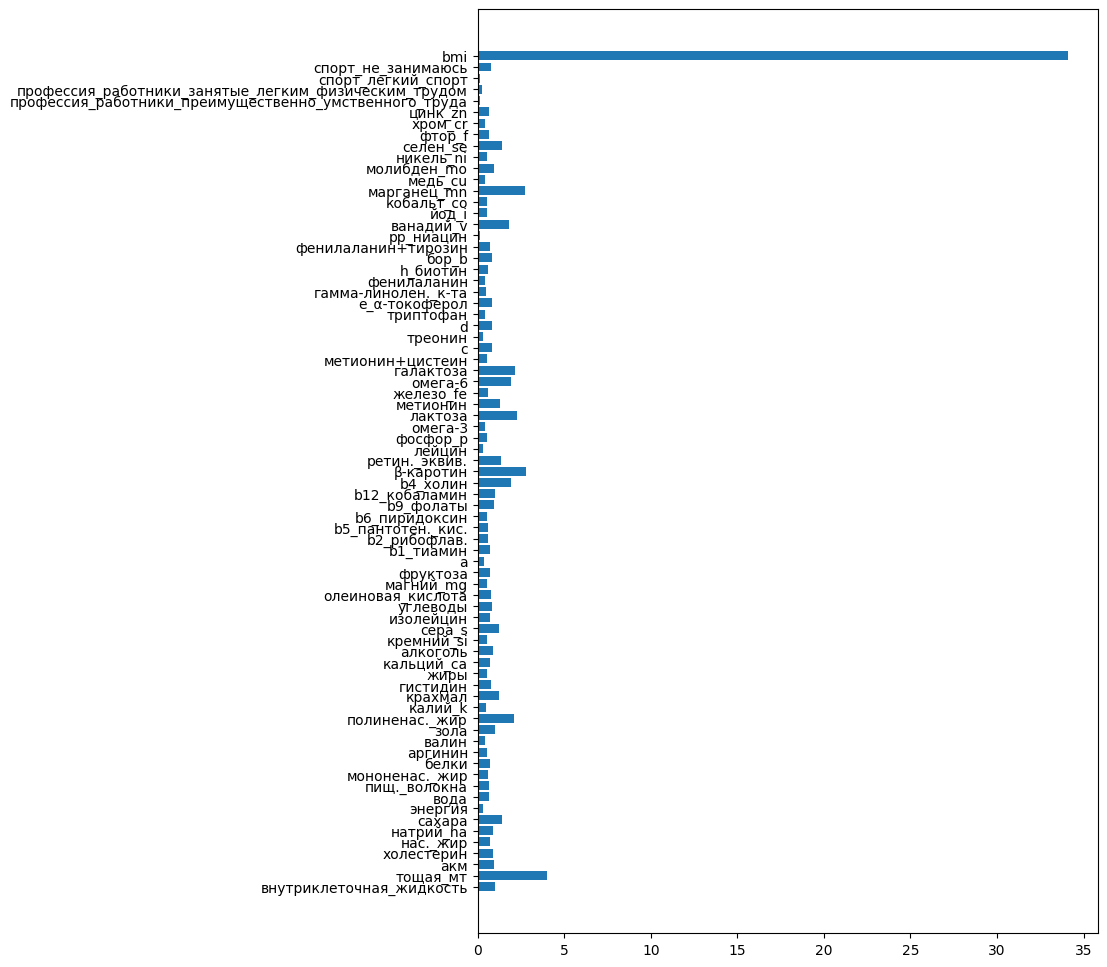

In [121]:
plt.figure(figsize=(8,12))
plt.barh(column_names, model.get_feature_importance(catboost.Pool(x_train)))

In [122]:
import heapq
importances = model.get_feature_importance(catboost.Pool(x_train))
max_imp = heapq.nlargest(9, importances)

features_selected_indx = np.where(np.isin(importances, max_imp))[0]
features_selected_indx

array([ 1, 15, 36, 37, 42, 45, 46, 62, 74])

In [123]:
features_selected = list(df.columns[features_selected_indx])
features_selected

['тощая_мт',
 'полиненас._жир',
 'b4_холин',
 'β-каротин',
 'лактоза',
 'омега-6',
 'галактоза',
 'марганец_mn',
 'bmi']

## Финальный набор признаков

Убираем из признаков ИМТ

In [124]:
features_selected.remove('bmi')
features_selected

['тощая_мт',
 'полиненас._жир',
 'b4_холин',
 'β-каротин',
 'лактоза',
 'омега-6',
 'галактоза',
 'марганец_mn']

In [125]:
features_selected_indx = []
for i in features_selected: features_selected_indx.append(list(x_train.columns).index(i))
features_selected_indx = sorted(features_selected_indx)
features_selected_indx

[1, 15, 36, 37, 42, 45, 46, 62]

In [126]:
x_train_selected = x_train.iloc[:,features_selected_indx]
x_test_selected = x_test.iloc[:,features_selected_indx]

<Axes: ylabel='Count'>

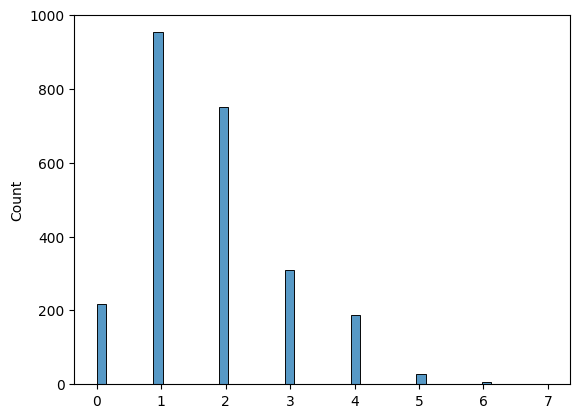

In [127]:
missing_features_selected = x_train_selected.isnull().sum(axis=1)
sns.histplot(missing_features_selected)

<Axes: ylabel='Count'>

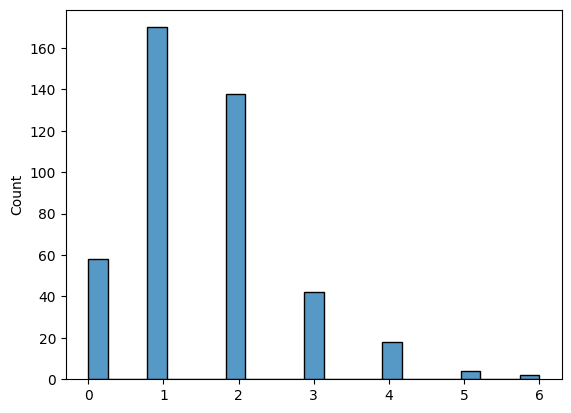

In [128]:
missing_features_selected = x_test_selected.isnull().sum(axis=1)
sns.histplot(missing_features_selected)

Видно, что в тренировочной и тестовой выборках с отобранными 9 параметрами, подавляющее большинство строк имеют 6 значимых признаков и более. Соответственно, на отобранных данных можн проводить обучение.

# Обучение моделей

Для работы с моделями будет использоваться алгоритм кросс-валидации для проверки значений метрик на тренировочной выборке, а итоговые значения метрик будут получаться на тестовой выборке.

Подбор оптимальных параметров происходит при помощи Optuna.

## 1. Рандомный лес

### 1. Imputer + RandomForest

In [129]:
it_imp = SimpleImputer(missing_values=np.nan, strategy='mean') #IterativeImputer(random_state=42)
x_train_imp = it_imp.fit_transform(x_train)
x_test_imp = it_imp.transform(x_test)

In [130]:
def param_search_rf(trial):
    params = {
        "criterion": 'log_loss',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10, 2),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 4, 1)
    }

    model = RandomForestClassifier(**params)
    model.fit(x_train_imp, y_train)
    predictions = model.predict(x_test_imp)
    return f1_score(y_test, predictions)

In [131]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(param_search_rf, n_trials=30)

[I 2024-11-11 11:04:23,216] A new study created in memory with name: no-name-0dbcb581-bb79-4659-b162-59bf2263e6c5
[I 2024-11-11 11:04:28,203] Trial 0 finished with value: 0.42500000000000004 and parameters: {'max_depth': 10, 'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.42500000000000004.
[I 2024-11-11 11:04:34,966] Trial 1 finished with value: 0.42500000000000004 and parameters: {'max_depth': 8, 'n_estimators': 600, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.42500000000000004.
[I 2024-11-11 11:04:38,150] Trial 2 finished with value: 0.422360248447205 and parameters: {'max_depth': 7, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.42500000000000004.
[I 2024-11-11 11:04:40,233] Trial 3 finished with value: 0.4213836477987421 and parameters: {'max_depth': 7, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 0 with valu

In [132]:
print('Best hyperparameters:', study_rf.best_params)
print('Best ROC-AUC score:', study_rf.best_value)

Best hyperparameters: {'max_depth': 9, 'n_estimators': 500, 'min_samples_split': 8, 'min_samples_leaf': 3}
Best ROC-AUC score: 0.4375


In [133]:
rfc_best = RandomForestClassifier(n_estimators = study_rf.best_params['n_estimators'],
                                  max_depth = study_rf.best_params['max_depth'],
                                  min_samples_split = study_rf.best_params['min_samples_split'],
                                  min_samples_leaf = study_rf.best_params['min_samples_leaf'],
                                  criterion='log_loss')
rfc_best.fit(x_train_imp, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=9, min_samples_leaf=3,
                       min_samples_split=8, n_estimators=500)

Метрики, получаемые из кросс-валидации

In [134]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(rfc_best, x_train_imp, y_train, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([3.86430359, 3.90195036, 3.87638235, 3.85154247, 3.76846457]),
 'score_time': array([0.07107186, 0.07837772, 0.08037782, 0.07839942, 0.07958198]),
 'test_accuracy': array([0.74897959, 0.84285714, 0.81020408, 0.81836735, 0.76122449]),
 'test_precision_macro': array([0.84055556, 0.8340812 , 0.79026916, 0.79210698, 0.73774409]),
 'test_recall_macro': array([0.61647571, 0.79707956, 0.76310589, 0.80673203, 0.76280188]),
 'test_f1_macro': array([0.61220958, 0.81106565, 0.77361134, 0.79817193, 0.74344287]),
 'test_roc_auc': array([0.91307074, 0.91151266, 0.88344829, 0.85806305, 0.82156226])}

In [135]:
from sklearn.metrics import fbeta_score

def f2_score(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

In [136]:
def f2_score_on_pr_rec(precision, recall):
  return (5*precision*recall)/(4*precision+recall)

In [137]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
rfc_best_cv_metrics = []
for metric in metrics: rfc_best_cv_metrics.append(scores[metric])
rfc_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
rfc_best_cv_metrics = np.array(rfc_best_cv_metrics)

In [138]:
def report(y_true, y_pred):
  print(classification_report(y_true, y_pred))
  cm = confusion_matrix(y_true, y_pred, normalize="all")
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, cmap="Reds")
  print("F2-score: ", f2_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.85      0.67       216
           1       0.68      0.31      0.43       216

    accuracy                           0.58       432
   macro avg       0.61      0.58      0.55       432
weighted avg       0.61      0.58      0.55       432

F2-score:  0.347871235721703


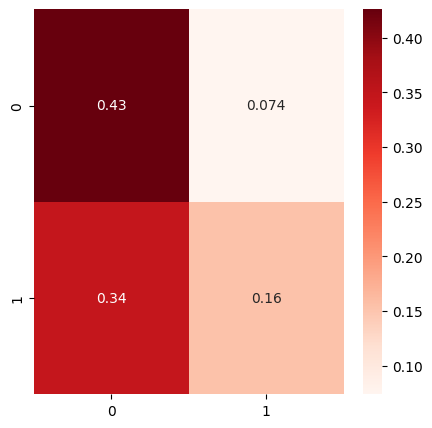

In [139]:
report(y_test, rfc_best.predict(x_test_imp))

### 2. XGBRFClassifier

In [140]:
def param_search_xgbrf(trial):
    params = {
        "criterion": 'log_loss',
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
    }

    model = XGBRFClassifier(**params)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [141]:
study_xgbrf = optuna.create_study(direction='maximize')
study_xgbrf.optimize(param_search_xgbrf, n_trials=30)

[I 2024-11-11 11:07:36,101] A new study created in memory with name: no-name-d48d960a-370f-4803-b4b8-f72a66b887a7


[11:07:36] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:07:38,133] Trial 0 finished with value: 0.48450704225352115 and parameters: {'max_depth': 10, 'n_estimators': 600}. Best is trial 0 with value: 0.48450704225352115.


[11:07:38] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:07:38,889] Trial 1 finished with value: 0.47863247863247865 and parameters: {'max_depth': 8, 'n_estimators': 300}. Best is trial 0 with value: 0.48450704225352115.


[11:07:38] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:07:39,122] Trial 2 finished with value: 0.4451219512195122 and parameters: {'max_depth': 3, 'n_estimators': 300}. Best is trial 0 with value: 0.48450704225352115.
[I 2024-11-11 11:07:39,281] Trial 3 finished with value: 0.44984802431610943 and parameters: {'max_depth': 3, 'n_estimators': 200}. Best is trial 0 with value: 0.48450704225352115.


[11:07:39] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[11:07:39] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:07:39,948] Trial 4 finished with value: 0.4391691394658754 and parameters: {'max_depth': 5, 'n_estimators': 500}. Best is trial 0 with value: 0.48450704225352115.


[11:07:39] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:07:41,195] Trial 5 finished with value: 0.4579710144927537 and parameters: {'max_depth': 7, 'n_estimators': 600}. Best is trial 0 with value: 0.48450704225352115.


[11:07:41] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:07:42,260] Trial 6 finished with value: 0.4437869822485207 and parameters: {'max_depth': 5, 'n_estimators': 800}. Best is trial 0 with value: 0.48450704225352115.


[11:07:42] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:07:43,148] Trial 7 finished with value: 0.4901408450704225 and parameters: {'max_depth': 9, 'n_estimators': 300}. Best is trial 7 with value: 0.4901408450704225.


[11:07:43] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:07:44,049] Trial 8 finished with value: 0.43529411764705883 and parameters: {'max_depth': 4, 'n_estimators': 800}. Best is trial 7 with value: 0.4901408450704225.


[11:07:44] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:07:44,135] Trial 9 finished with value: 0.4451219512195122 and parameters: {'max_depth': 3, 'n_estimators': 100}. Best is trial 7 with value: 0.4901408450704225.


[11:07:44] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:07:47,522] Trial 10 finished with value: 0.48876404494382025 and parameters: {'max_depth': 10, 'n_estimators': 1000}. Best is trial 7 with value: 0.4901408450704225.


[11:07:47] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:07:50,930] Trial 11 finished with value: 0.48876404494382025 and parameters: {'max_depth': 10, 'n_estimators': 1000}. Best is trial 7 with value: 0.4901408450704225.


[11:07:50] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:07:52,144] Trial 12 finished with value: 0.4901408450704225 and parameters: {'max_depth': 9, 'n_estimators': 400}. Best is trial 7 with value: 0.4901408450704225.


[11:07:52] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:07:53,183] Trial 13 finished with value: 0.47293447293447294 and parameters: {'max_depth': 8, 'n_estimators': 400}. Best is trial 7 with value: 0.4901408450704225.


[11:07:53] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:07:53,459] Trial 14 finished with value: 0.4783861671469741 and parameters: {'max_depth': 8, 'n_estimators': 100}. Best is trial 7 with value: 0.4901408450704225.


[11:07:53] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:07:54,700] Trial 15 finished with value: 0.4901408450704225 and parameters: {'max_depth': 9, 'n_estimators': 400}. Best is trial 7 with value: 0.4901408450704225.


[11:07:54] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:07:55,768] Trial 16 finished with value: 0.46551724137931033 and parameters: {'max_depth': 7, 'n_estimators': 500}. Best is trial 7 with value: 0.4901408450704225.


[11:07:55] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:07:56,685] Trial 17 finished with value: 0.4901408450704225 and parameters: {'max_depth': 9, 'n_estimators': 300}. Best is trial 7 with value: 0.4901408450704225.


[11:07:56] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:07:57,885] Trial 18 finished with value: 0.4574780058651027 and parameters: {'max_depth': 6, 'n_estimators': 700}. Best is trial 7 with value: 0.4901408450704225.


[11:07:57] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:07:58,501] Trial 19 finished with value: 0.49002849002849 and parameters: {'max_depth': 9, 'n_estimators': 200}. Best is trial 7 with value: 0.4901408450704225.


[11:07:58] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:07:59,719] Trial 20 finished with value: 0.4901408450704225 and parameters: {'max_depth': 9, 'n_estimators': 400}. Best is trial 7 with value: 0.4901408450704225.


[11:07:59] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:08:00,945] Trial 21 finished with value: 0.4901408450704225 and parameters: {'max_depth': 9, 'n_estimators': 400}. Best is trial 7 with value: 0.4901408450704225.


[11:08:00] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:08:01,975] Trial 22 finished with value: 0.47293447293447294 and parameters: {'max_depth': 8, 'n_estimators': 400}. Best is trial 7 with value: 0.4901408450704225.


[11:08:01] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:08:02,691] Trial 23 finished with value: 0.4872521246458923 and parameters: {'max_depth': 10, 'n_estimators': 200}. Best is trial 7 with value: 0.4901408450704225.


[11:08:02] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:08:03,765] Trial 24 finished with value: 0.46551724137931033 and parameters: {'max_depth': 7, 'n_estimators': 500}. Best is trial 7 with value: 0.4901408450704225.


[11:08:03] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:08:04,679] Trial 25 finished with value: 0.4901408450704225 and parameters: {'max_depth': 9, 'n_estimators': 300}. Best is trial 7 with value: 0.4901408450704225.


[11:08:04] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:08:05,707] Trial 26 finished with value: 0.4574780058651027 and parameters: {'max_depth': 6, 'n_estimators': 600}. Best is trial 7 with value: 0.4901408450704225.


[11:08:05] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:08:06,244] Trial 27 finished with value: 0.4770114942528736 and parameters: {'max_depth': 8, 'n_estimators': 200}. Best is trial 7 with value: 0.4901408450704225.


[11:08:06] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:08:07,448] Trial 28 finished with value: 0.4901408450704225 and parameters: {'max_depth': 9, 'n_estimators': 400}. Best is trial 7 with value: 0.4901408450704225.


[11:08:07] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



[I 2024-11-11 11:08:09,831] Trial 29 finished with value: 0.4943820224719101 and parameters: {'max_depth': 10, 'n_estimators': 700}. Best is trial 29 with value: 0.4943820224719101.


In [142]:
print('Best hyperparameters:', study_xgbrf.best_params)
print('Best f1 score:', study_xgbrf.best_value)

Best hyperparameters: {'max_depth': 10, 'n_estimators': 700}
Best f1 score: 0.4943820224719101


In [143]:
xgb_rfc_best = XGBRFClassifier(criterion='log_loss', max_depth=study_xgbrf.best_params['max_depth'], n_estimators=study_xgbrf.best_params['n_estimators'])
xgb_rfc_best.fit(x_train_selected, y_train)

[11:08:09] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                criterion='log_loss', early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=10, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=700, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=None, ...)

In [144]:
scoring = ['accuracy', 'roc_auc','precision_macro', 'recall_macro','f1_macro']
scores = cross_validate(xgb_rfc_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())

[11:08:12] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[11:08:14] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[11:08:15] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[11:08:17] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.

[11:08:19] WARNING: ../src/learner.cc:767: 
Parameters: { "criterion" } are not used.



['fit_time',
 'score_time',
 'test_accuracy',
 'test_f1_macro',
 'test_precision_macro',
 'test_recall_macro',
 'test_roc_auc']

In [145]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
xgb_rfc_best_cv_metrics = []
for metric in metrics: xgb_rfc_best_cv_metrics.append(scores[metric])
xgb_rfc_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
xgb_rfc_best_cv_metrics  = np.array( xgb_rfc_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.56      0.76      0.65       216
           1       0.63      0.41      0.49       216

    accuracy                           0.58       432
   macro avg       0.60      0.58      0.57       432
weighted avg       0.60      0.58      0.57       432

F2-score:  0.4382470119521912


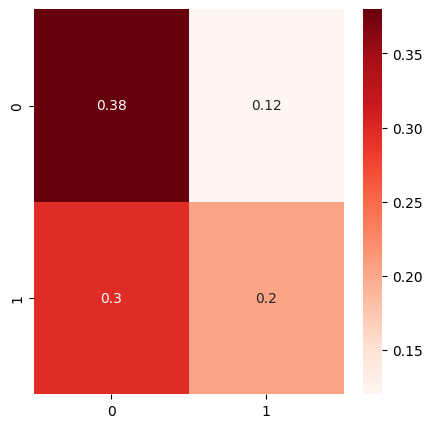

In [146]:
report(y_test, xgb_rfc_best.predict(x_test_selected))

## Бустинги

### Catboost

In [147]:
model = CatBoostClassifier(random_seed=42)

In [148]:
model.fit(
    x_train_selected,
    y_train,
    eval_set=(x_test_selected, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

Learning rate set to 0.03954
0:	learn: 0.6792591	test: 0.6906360	best: 0.6906360 (0)	total: 1.49ms	remaining: 1.48s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.6832590887
bestIteration = 8

Shrink model to first 9 iterations.


In [149]:
f1_score(y_test, model.predict(x_test_selected))

0.39622641509433965

In [150]:
model.get_feature_importance(catboost.Pool(x_train_selected))

array([44.2181409 , 17.12386828,  4.25472666, 12.78165189,  7.48704021,
        1.81115746,  7.25733035,  5.06608424])

In [151]:
def param_search_cb(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "random_strength": trial.suggest_float("random_strength", 0.5, 2.)
    }

    model = CatBoostClassifier(**params, silent=True)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [152]:
study_cb = optuna.create_study(direction='maximize')
study_cb.optimize(param_search_cb, n_trials=30)

[I 2024-11-11 11:08:22,408] A new study created in memory with name: no-name-5cb0fef5-e6b8-417e-a126-84a561e74c04
[I 2024-11-11 11:08:23,090] Trial 0 finished with value: 0.40880503144654085 and parameters: {'learning_rate': 0.0015377241268048434, 'depth': 2, 'subsample': 0.43605331854700446, 'colsample_bylevel': 0.8939682947667739, 'min_data_in_leaf': 96, 'random_strength': 1.352074279305248}. Best is trial 0 with value: 0.40880503144654085.
[I 2024-11-11 11:08:24,120] Trial 1 finished with value: 0.4233128834355828 and parameters: {'learning_rate': 0.0016210456601525591, 'depth': 5, 'subsample': 0.6681018519618688, 'colsample_bylevel': 0.5162661857616868, 'min_data_in_leaf': 18, 'random_strength': 0.8561191146177152}. Best is trial 1 with value: 0.4233128834355828.
[I 2024-11-11 11:08:26,216] Trial 2 finished with value: 0.43553008595988535 and parameters: {'learning_rate': 0.006186779672657476, 'depth': 8, 'subsample': 0.4547963281201335, 'colsample_bylevel': 0.903173738689989, 'min

In [153]:
print('Best hyperparameters:', study_cb.best_params)
print('Best f1 score:', study_cb.best_value)

Best hyperparameters: {'learning_rate': 0.09054723836140889, 'depth': 5, 'subsample': 0.9673664645790578, 'colsample_bylevel': 0.5852693826996722, 'min_data_in_leaf': 48, 'random_strength': 1.9641154359408821}
Best f1 score: 0.48633879781420764


In [154]:
cb_best = CatBoostClassifier(learning_rate=study_cb.best_params['learning_rate'],
                             depth=study_cb.best_params['depth'],
                             random_seed=42,
                             subsample=study_cb.best_params['subsample'],
                             colsample_bylevel=study_cb.best_params['colsample_bylevel'],
                             min_data_in_leaf =study_cb.best_params['min_data_in_leaf'],
                             random_strength=study_cb.best_params['random_strength'])
cb_best.fit(x_train_selected, y_train)

0:	learn: 0.6637250	total: 1.07ms	remaining: 1.07s
1:	learn: 0.6419660	total: 2.21ms	remaining: 1.1s
2:	learn: 0.6231933	total: 3.26ms	remaining: 1.08s
3:	learn: 0.6097581	total: 4.29ms	remaining: 1.07s
4:	learn: 0.5941808	total: 5.34ms	remaining: 1.06s
5:	learn: 0.5828861	total: 6.35ms	remaining: 1.05s
6:	learn: 0.5727212	total: 7.41ms	remaining: 1.05s
7:	learn: 0.5653415	total: 8.42ms	remaining: 1.04s
8:	learn: 0.5578059	total: 9.47ms	remaining: 1.04s
9:	learn: 0.5504177	total: 10.5ms	remaining: 1.04s
10:	learn: 0.5453857	total: 11.5ms	remaining: 1.03s
11:	learn: 0.5400057	total: 12.5ms	remaining: 1.03s
12:	learn: 0.5333012	total: 13.5ms	remaining: 1.02s
13:	learn: 0.5275807	total: 14.5ms	remaining: 1.02s
14:	learn: 0.5229664	total: 15.5ms	remaining: 1.02s
15:	learn: 0.5177138	total: 16.6ms	remaining: 1.02s
16:	learn: 0.5135314	total: 17.6ms	remaining: 1.02s
17:	learn: 0.5113592	total: 18.7ms	remaining: 1.02s
18:	learn: 0.5090147	total: 19.8ms	remaining: 1.02s
19:	learn: 0.5063514	to

In [155]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(cb_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())
scores

0:	learn: 0.6620640	total: 986us	remaining: 985ms
1:	learn: 0.6410072	total: 2.07ms	remaining: 1.03s
2:	learn: 0.6237429	total: 3ms	remaining: 996ms
3:	learn: 0.6098923	total: 3.96ms	remaining: 986ms
4:	learn: 0.5925386	total: 4.95ms	remaining: 986ms
5:	learn: 0.5811135	total: 5.97ms	remaining: 990ms
6:	learn: 0.5715463	total: 6.96ms	remaining: 987ms
7:	learn: 0.5642461	total: 7.97ms	remaining: 989ms
8:	learn: 0.5558072	total: 8.88ms	remaining: 978ms
9:	learn: 0.5481525	total: 9.82ms	remaining: 973ms
10:	learn: 0.5425432	total: 10.8ms	remaining: 967ms
11:	learn: 0.5363907	total: 11.7ms	remaining: 963ms
12:	learn: 0.5318094	total: 12.6ms	remaining: 960ms
13:	learn: 0.5260844	total: 13.6ms	remaining: 954ms
14:	learn: 0.5209005	total: 14.5ms	remaining: 952ms
15:	learn: 0.5145059	total: 15.4ms	remaining: 949ms
16:	learn: 0.5110022	total: 16.4ms	remaining: 946ms
17:	learn: 0.5079648	total: 17.3ms	remaining: 944ms
18:	learn: 0.5049939	total: 18.2ms	remaining: 941ms
19:	learn: 0.5011533	total

{'fit_time': array([0.99705791, 1.02133703, 1.03462839, 1.0331223 , 1.14496136]),
 'score_time': array([0.00900531, 0.00776434, 0.00719309, 0.00697327, 0.01021338]),
 'test_accuracy': array([0.70612245, 0.76122449, 0.73061224, 0.71428571, 0.70612245]),
 'test_precision_macro': array([0.7782516 , 0.72833583, 0.69081972, 0.67627593, 0.68232777]),
 'test_recall_macro': array([0.55207205, 0.70887723, 0.66007334, 0.68067035, 0.70240742]),
 'test_f1_macro': array([0.51      , 0.71629346, 0.66857283, 0.67824243, 0.68531469]),
 'test_roc_auc': array([0.82256931, 0.81914914, 0.74629957, 0.74394345, 0.75051778])}

In [156]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
cb_best_cv_metrics = []
for metric in metrics: cb_best_cv_metrics.append(scores[metric])
cb_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
cb_best_cv_metrics = np.array(cb_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.53      0.70      0.60       216
           1       0.56      0.38      0.46       216

    accuracy                           0.54       432
   macro avg       0.55      0.54      0.53       432
weighted avg       0.55      0.54      0.53       432

F2-score:  0.41007905138339923


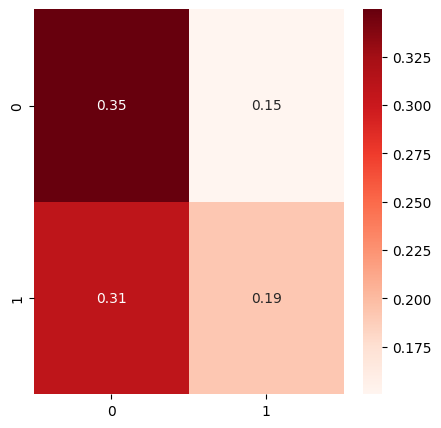

In [157]:
report(y_test, cb_best.predict(x_test_selected))

### XGBoost

In [158]:
model = XGBClassifier()

In [159]:
model.fit(
    x_train_selected,
    y_train,
    )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [160]:
def param_search_xgb(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [161]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(param_search_xgb, n_trials=30)

[I 2024-11-11 11:09:05,370] A new study created in memory with name: no-name-44c9fff6-f32d-444c-8953-cab5553dd0b9


[11:09:05] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:09:05,997] Trial 0 finished with value: 0.45197740112994345 and parameters: {'learning_rate': 0.009293221974531354, 'max_depth': 251, 'n_estimators': 400, 'subsample': 0.14741920899511773, 'colsample_bylevel': 0.8058299607818042, 'gamma': 1.0331186333563631}. Best is trial 0 with value: 0.45197740112994345.


[11:09:05] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:09:06,765] Trial 1 finished with value: 0.4699140401146132 and parameters: {'learning_rate': 0.006112900822858835, 'max_depth': 463, 'n_estimators': 600, 'subsample': 0.11456807880936687, 'colsample_bylevel': 0.42553281753768557, 'gamma': 1.4112941114741806}. Best is trial 1 with value: 0.4699140401146132.


[11:09:06] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:09:08,031] Trial 2 finished with value: 0.43731778425655976 and parameters: {'learning_rate': 0.004200896228796111, 'max_depth': 169, 'n_estimators': 800, 'subsample': 0.275712426113901, 'colsample_bylevel': 0.11880000728188676, 'gamma': 2.23446676390639}. Best is trial 1 with value: 0.4699140401146132.


[11:09:08] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:09:09,563] Trial 3 finished with value: 0.5159574468085106 and parameters: {'learning_rate': 0.03545793380568622, 'max_depth': 471, 'n_estimators': 600, 'subsample': 0.36594747615912443, 'colsample_bylevel': 0.49648232022682987, 'gamma': 1.2086923225124555}. Best is trial 3 with value: 0.5159574468085106.


[11:09:09] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:09:11,852] Trial 4 finished with value: 0.4482758620689656 and parameters: {'learning_rate': 0.001787063415720033, 'max_depth': 449, 'n_estimators': 1000, 'subsample': 0.34482243289903863, 'colsample_bylevel': 0.3727490440101841, 'gamma': 2.7160852907540636}. Best is trial 3 with value: 0.5159574468085106.


[11:09:11] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:09:12,875] Trial 5 finished with value: 0.47222222222222227 and parameters: {'learning_rate': 0.04044305067030544, 'max_depth': 359, 'n_estimators': 300, 'subsample': 0.9336734390488234, 'colsample_bylevel': 0.23925635950448276, 'gamma': 1.3414376023632966}. Best is trial 3 with value: 0.5159574468085106.


[11:09:12] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:09:13,538] Trial 6 finished with value: 0.454054054054054 and parameters: {'learning_rate': 0.06894566668738396, 'max_depth': 431, 'n_estimators': 400, 'subsample': 0.23299321696644132, 'colsample_bylevel': 0.6387743328524413, 'gamma': 1.9576489834965793}. Best is trial 3 with value: 0.5159574468085106.


[11:09:13] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:09:18,116] Trial 7 finished with value: 0.47826086956521735 and parameters: {'learning_rate': 0.01114676415279135, 'max_depth': 271, 'n_estimators': 800, 'subsample': 0.9461936766550089, 'colsample_bylevel': 0.380691919816141, 'gamma': 1.0255824047542157}. Best is trial 3 with value: 0.5159574468085106.


[11:09:18] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:09:21,438] Trial 8 finished with value: 0.4759206798866855 and parameters: {'learning_rate': 0.002416314246388491, 'max_depth': 137, 'n_estimators': 900, 'subsample': 0.6488840189182542, 'colsample_bylevel': 0.42627741145606657, 'gamma': 1.9307732894764056}. Best is trial 3 with value: 0.5159574468085106.


[11:09:21] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:09:21,729] Trial 9 finished with value: 0.45983379501385035 and parameters: {'learning_rate': 0.09304078200619109, 'max_depth': 275, 'n_estimators': 100, 'subsample': 0.6335546625141761, 'colsample_bylevel': 0.24372076132685977, 'gamma': 2.9652942109772154}. Best is trial 3 with value: 0.5159574468085106.


[11:09:21] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:09:23,382] Trial 10 finished with value: 0.46994535519125685 and parameters: {'learning_rate': 0.028493402167609115, 'max_depth': 361, 'n_estimators': 600, 'subsample': 0.4205021670309499, 'colsample_bylevel': 0.909231752591156, 'gamma': 0.22365889731757016}. Best is trial 3 with value: 0.5159574468085106.


[11:09:23] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:09:27,484] Trial 11 finished with value: 0.48913043478260865 and parameters: {'learning_rate': 0.01936815726974225, 'max_depth': 219, 'n_estimators': 700, 'subsample': 0.988497171959005, 'colsample_bylevel': 0.6097564214079725, 'gamma': 0.7027341793201595}. Best is trial 3 with value: 0.5159574468085106.


[11:09:27] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:09:30,658] Trial 12 finished with value: 0.4861878453038674 and parameters: {'learning_rate': 0.020584176726714407, 'max_depth': 206, 'n_estimators': 700, 'subsample': 0.7460980140740505, 'colsample_bylevel': 0.6288637378363047, 'gamma': 0.5889886217056803}. Best is trial 3 with value: 0.5159574468085106.


[11:09:30] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:09:32,342] Trial 13 finished with value: 0.4848484848484848 and parameters: {'learning_rate': 0.02135345919254812, 'max_depth': 356, 'n_estimators': 500, 'subsample': 0.47735913063237034, 'colsample_bylevel': 0.6265489610683552, 'gamma': 0.658505687009425}. Best is trial 3 with value: 0.5159574468085106.


[11:09:32] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:09:35,065] Trial 14 finished with value: 0.4986449864498645 and parameters: {'learning_rate': 0.0418358472931613, 'max_depth': 113, 'n_estimators': 700, 'subsample': 0.7973158194690595, 'colsample_bylevel': 0.7392900851334714, 'gamma': 0.20991738646641023}. Best is trial 3 with value: 0.5159574468085106.


[11:09:35] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:09:36,059] Trial 15 finished with value: 0.47777777777777775 and parameters: {'learning_rate': 0.054197981500647315, 'max_depth': 117, 'n_estimators': 200, 'subsample': 0.806893318263801, 'colsample_bylevel': 0.7635904235752164, 'gamma': 0.20313445015721432}. Best is trial 3 with value: 0.5159574468085106.


[11:09:36] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:09:37,977] Trial 16 finished with value: 0.47567567567567565 and parameters: {'learning_rate': 0.04061423107443384, 'max_depth': 322, 'n_estimators': 500, 'subsample': 0.5854243653766882, 'colsample_bylevel': 0.9886879613655355, 'gamma': 1.7769881624944475}. Best is trial 3 with value: 0.5159574468085106.


[11:09:38] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:09:41,349] Trial 17 finished with value: 0.48066298342541436 and parameters: {'learning_rate': 0.01252754474557854, 'max_depth': 401, 'n_estimators': 700, 'subsample': 0.763274940045988, 'colsample_bylevel': 0.7316792617800953, 'gamma': 1.071040196410313}. Best is trial 3 with value: 0.5159574468085106.


[11:09:41] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:09:44,364] Trial 18 finished with value: 0.4715447154471545 and parameters: {'learning_rate': 0.09030671475886258, 'max_depth': 499, 'n_estimators': 1000, 'subsample': 0.5114988840216463, 'colsample_bylevel': 0.5343943589814867, 'gamma': 2.340638758392005}. Best is trial 3 with value: 0.5159574468085106.


[11:09:44] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:09:46,178] Trial 19 finished with value: 0.47956403269754766 and parameters: {'learning_rate': 0.031199042373893166, 'max_depth': 100, 'n_estimators': 800, 'subsample': 0.3433488821277527, 'colsample_bylevel': 0.8593086987656842, 'gamma': 0.3950244112081354}. Best is trial 3 with value: 0.5159574468085106.


[11:09:46] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:09:47,848] Trial 20 finished with value: 0.48450704225352115 and parameters: {'learning_rate': 0.0010632107250664478, 'max_depth': 171, 'n_estimators': 400, 'subsample': 0.8539924274183235, 'colsample_bylevel': 0.5179869060817724, 'gamma': 1.5777089629891776}. Best is trial 3 with value: 0.5159574468085106.


[11:09:47] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:09:52,047] Trial 21 finished with value: 0.49180327868852464 and parameters: {'learning_rate': 0.017939460365752842, 'max_depth': 232, 'n_estimators': 700, 'subsample': 0.9918694698488678, 'colsample_bylevel': 0.5460944112905041, 'gamma': 0.7363277008716282}. Best is trial 3 with value: 0.5159574468085106.


[11:09:52] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:09:54,952] Trial 22 finished with value: 0.47382920110192833 and parameters: {'learning_rate': 0.05274073812124234, 'max_depth': 309, 'n_estimators': 600, 'subsample': 0.8841505432361408, 'colsample_bylevel': 0.5158777233698092, 'gamma': 0.8714354364520838}. Best is trial 3 with value: 0.5159574468085106.


[11:09:54] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:09:57,901] Trial 23 finished with value: 0.48219178082191777 and parameters: {'learning_rate': 0.013630840700135441, 'max_depth': 220, 'n_estimators': 700, 'subsample': 0.677488020810792, 'colsample_bylevel': 0.717534966143308, 'gamma': 0.4366973370461281}. Best is trial 3 with value: 0.5159574468085106.


[11:09:57] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:10:02,703] Trial 24 finished with value: 0.46703296703296704 and parameters: {'learning_rate': 0.03074716738430011, 'max_depth': 178, 'n_estimators': 900, 'subsample': 0.9991875302464975, 'colsample_bylevel': 0.305356280621768, 'gamma': 1.26065840280663}. Best is trial 3 with value: 0.5159574468085106.


[11:10:02] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:10:04,999] Trial 25 finished with value: 0.4804469273743017 and parameters: {'learning_rate': 0.006830808961211321, 'max_depth': 138, 'n_estimators': 500, 'subsample': 0.7213521893771166, 'colsample_bylevel': 0.5552617567950706, 'gamma': 0.8155158192557608}. Best is trial 3 with value: 0.5159574468085106.


[11:10:05] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:10:09,344] Trial 26 finished with value: 0.4904632152588556 and parameters: {'learning_rate': 0.017819936082980985, 'max_depth': 246, 'n_estimators': 900, 'subsample': 0.8313052246923552, 'colsample_bylevel': 0.6836548172198559, 'gamma': 0.4405471661209555}. Best is trial 3 with value: 0.5159574468085106.


[11:10:09] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:10:10,898] Trial 27 finished with value: 0.4972375690607735 and parameters: {'learning_rate': 0.045186768943263136, 'max_depth': 401, 'n_estimators': 600, 'subsample': 0.43220357505730134, 'colsample_bylevel': 0.45509661935672124, 'gamma': 0.10609365343134436}. Best is trial 3 with value: 0.5159574468085106.


[11:10:10] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:10:12,082] Trial 28 finished with value: 0.46408839779005523 and parameters: {'learning_rate': 0.05493995660392435, 'max_depth': 400, 'n_estimators': 600, 'subsample': 0.419291355226841, 'colsample_bylevel': 0.07298844709971974, 'gamma': 0.15555125054459848}. Best is trial 3 with value: 0.5159574468085106.


[11:10:12] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:10:12,446] Trial 29 finished with value: 0.532258064516129 and parameters: {'learning_rate': 0.0734836788637486, 'max_depth': 498, 'n_estimators': 400, 'subsample': 0.057008457781611455, 'colsample_bylevel': 0.840343528684672, 'gamma': 0.990642952996237}. Best is trial 29 with value: 0.532258064516129.


In [162]:
print('Best hyperparameters:', study_xgb.best_params)
print('Best f1 score:', study_xgb.best_value)

Best hyperparameters: {'learning_rate': 0.0734836788637486, 'max_depth': 498, 'n_estimators': 400, 'subsample': 0.057008457781611455, 'colsample_bylevel': 0.840343528684672, 'gamma': 0.990642952996237}
Best f1 score: 0.532258064516129


In [163]:
xgb_best = XGBClassifier(learning_rate=study_xgb.best_params['learning_rate'],
                         max_depth=study_xgb.best_params['max_depth'],
                         n_estimators = study_xgb.best_params['n_estimators'],
                         random_seed=42,
                         subsample=study_xgb.best_params['subsample'],
                         colsample_bylevel= study_xgb.best_params['colsample_bylevel'],
                         gamma=study_xgb.best_params['gamma'])
xgb_best.fit(x_train_selected, y_train)

[11:10:12] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.840343528684672, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.990642952996237, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.0734836788637486, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=498, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_seed=42, ...)

In [164]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(xgb_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())
scores

[11:10:12] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[11:10:13] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[11:10:13] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[11:10:13] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.

[11:10:13] WARNING: ../src/learner.cc:767: 
Parameters: { "random_seed" } are not used.



{'fit_time': array([0.25986886, 0.24858284, 0.23550773, 0.24395156, 0.25100946]),
 'score_time': array([0.01272631, 0.01334071, 0.01098013, 0.01276612, 0.01075292]),
 'test_accuracy': array([0.70408163, 0.74897959, 0.73469388, 0.73469388, 0.72653061]),
 'test_precision_macro': array([0.79296139, 0.71306913, 0.69531566, 0.69992117, 0.69327633]),
 'test_recall_macro': array([0.54729332, 0.69491155, 0.67453305, 0.70721465, 0.70444052]),
 'test_f1_macro': array([0.50010905, 0.7017444 , 0.68165917, 0.7030303 , 0.69741378]),
 'test_roc_auc': array([0.81889263, 0.79507496, 0.75591404, 0.76017025, 0.75781413])}

In [165]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
xgb_best_cv_metrics = []
for metric in metrics: xgb_best_cv_metrics.append(scores[metric])
xgb_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
xgb_best_cv_metrics = np.array(xgb_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.58      0.74      0.65       216
           1       0.63      0.46      0.53       216

    accuracy                           0.60       432
   macro avg       0.61      0.60      0.59       432
weighted avg       0.61      0.60      0.59       432

F2-score:  0.48529411764705876


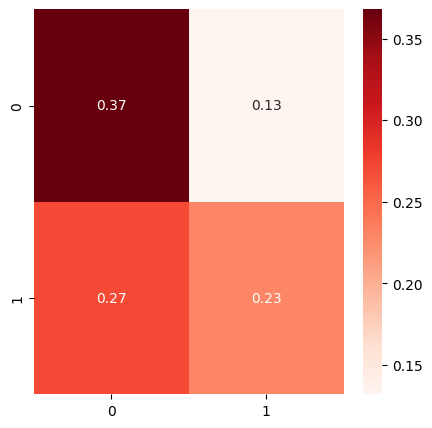

In [166]:
report(y_test, xgb_best.predict(x_test_selected))

### LightGBM

In [167]:
model = LGBMClassifier()

In [168]:
model.fit(
    x_train_selected,
    y_train,
    )

LGBMClassifier()

In [169]:
def param_search_lgbm(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 100, 500),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, 100),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "gamma": trial.suggest_float("gamma", 0.1, 3.)
    }

    model = XGBClassifier(**params, silent=True)
    model.fit(x_train_selected, y_train)
    predictions = model.predict(x_test_selected)
    return f1_score(y_test, predictions)

In [170]:
study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(param_search_lgbm, n_trials=30)

[I 2024-11-11 11:10:14,488] A new study created in memory with name: no-name-49997255-d962-44e0-8e16-4d88c37d0470


[11:10:14] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:10:14,982] Trial 0 finished with value: 0.39375000000000004 and parameters: {'learning_rate': 0.0011709217750300435, 'max_depth': 232, 'n_estimators': 200, 'subsample': 0.8924018097837192, 'colsample_bylevel': 0.11053874018470304, 'gamma': 0.14777530539018086}. Best is trial 0 with value: 0.39375000000000004.


[11:10:14] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:10:17,659] Trial 1 finished with value: 0.4835164835164836 and parameters: {'learning_rate': 0.035569858854121866, 'max_depth': 181, 'n_estimators': 800, 'subsample': 0.6494247811105422, 'colsample_bylevel': 0.5168135891712129, 'gamma': 0.561146611680579}. Best is trial 1 with value: 0.4835164835164836.


[11:10:17] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:10:22,422] Trial 2 finished with value: 0.4904632152588556 and parameters: {'learning_rate': 0.05258969774900161, 'max_depth': 187, 'n_estimators': 600, 'subsample': 0.988253981197713, 'colsample_bylevel': 0.9858623637325095, 'gamma': 2.1525623765659527}. Best is trial 2 with value: 0.4904632152588556.


[11:10:22] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:10:24,052] Trial 3 finished with value: 0.4666666666666666 and parameters: {'learning_rate': 0.007859005203396083, 'max_depth': 375, 'n_estimators': 600, 'subsample': 0.35583092296075547, 'colsample_bylevel': 0.4626889075387686, 'gamma': 2.046313625480645}. Best is trial 2 with value: 0.4904632152588556.


[11:10:24] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:10:25,052] Trial 4 finished with value: 0.44314868804664725 and parameters: {'learning_rate': 0.002406082787658103, 'max_depth': 420, 'n_estimators': 1000, 'subsample': 0.07202129545427186, 'colsample_bylevel': 0.4745494518202154, 'gamma': 0.7698027494919524}. Best is trial 2 with value: 0.4904632152588556.


[11:10:25] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:10:26,828] Trial 5 finished with value: 0.47222222222222227 and parameters: {'learning_rate': 0.0721399090944777, 'max_depth': 398, 'n_estimators': 600, 'subsample': 0.42382586657108967, 'colsample_bylevel': 0.8522169268389943, 'gamma': 2.2242696749165978}. Best is trial 2 with value: 0.4904632152588556.


[11:10:26] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:10:31,446] Trial 6 finished with value: 0.4848484848484848 and parameters: {'learning_rate': 0.007656940506849654, 'max_depth': 348, 'n_estimators': 900, 'subsample': 0.8178516844284007, 'colsample_bylevel': 0.8426272895928272, 'gamma': 0.37889886467782175}. Best is trial 2 with value: 0.4904632152588556.


[11:10:31] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:10:33,090] Trial 7 finished with value: 0.4632768361581921 and parameters: {'learning_rate': 0.001873114360093245, 'max_depth': 108, 'n_estimators': 800, 'subsample': 0.2738467727558668, 'colsample_bylevel': 0.37613123910181645, 'gamma': 2.0289934169808133}. Best is trial 2 with value: 0.4904632152588556.


[11:10:33] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:10:36,112] Trial 8 finished with value: 0.4748603351955308 and parameters: {'learning_rate': 0.0060190440375818164, 'max_depth': 210, 'n_estimators': 800, 'subsample': 0.7019144049871845, 'colsample_bylevel': 0.3357764615504488, 'gamma': 2.6740620748928863}. Best is trial 2 with value: 0.4904632152588556.


[11:10:36] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:10:36,514] Trial 9 finished with value: 0.4619718309859155 and parameters: {'learning_rate': 0.05705837260882646, 'max_depth': 204, 'n_estimators': 200, 'subsample': 0.4236489333979863, 'colsample_bylevel': 0.07485880518435716, 'gamma': 2.8631261664142253}. Best is trial 2 with value: 0.4904632152588556.


[11:10:36] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:10:39,053] Trial 10 finished with value: 0.4808743169398907 and parameters: {'learning_rate': 0.029034927787402468, 'max_depth': 495, 'n_estimators': 400, 'subsample': 0.9306145018179657, 'colsample_bylevel': 0.9766337123882187, 'gamma': 1.2976697118080258}. Best is trial 2 with value: 0.4904632152588556.


[11:10:39] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:10:46,339] Trial 11 finished with value: 0.4932249322493224 and parameters: {'learning_rate': 0.017211226043657064, 'max_depth': 315, 'n_estimators': 1000, 'subsample': 0.9955028185964713, 'colsample_bylevel': 0.7524175264761048, 'gamma': 1.4069122168732715}. Best is trial 11 with value: 0.4932249322493224.


[11:10:46] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:10:48,970] Trial 12 finished with value: 0.4709141274238227 and parameters: {'learning_rate': 0.019062875923176115, 'max_depth': 294, 'n_estimators': 400, 'subsample': 0.9839617334897046, 'colsample_bylevel': 0.7662088207307176, 'gamma': 1.3029664516592774}. Best is trial 11 with value: 0.4932249322493224.


[11:10:48] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:10:50,855] Trial 13 finished with value: 0.46961325966850836 and parameters: {'learning_rate': 0.016480125362519405, 'max_depth': 282, 'n_estimators': 400, 'subsample': 0.7527469677862472, 'colsample_bylevel': 0.6749530144950198, 'gamma': 1.5627487382242138}. Best is trial 11 with value: 0.4932249322493224.


[11:10:50] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:10:54,348] Trial 14 finished with value: 0.4793388429752066 and parameters: {'learning_rate': 0.08780613375807081, 'max_depth': 118, 'n_estimators': 1000, 'subsample': 0.6018344271606902, 'colsample_bylevel': 0.9948055064644722, 'gamma': 1.6301283095866197}. Best is trial 11 with value: 0.4932249322493224.


[11:10:54] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:10:58,057] Trial 15 finished with value: 0.47956403269754766 and parameters: {'learning_rate': 0.015053959441108617, 'max_depth': 259, 'n_estimators': 700, 'subsample': 0.8104267852704383, 'colsample_bylevel': 0.6270723261828934, 'gamma': 2.429242520957752}. Best is trial 11 with value: 0.4932249322493224.


[11:10:58] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:11:00,723] Trial 16 finished with value: 0.46831955922865015 and parameters: {'learning_rate': 0.05097917060110164, 'max_depth': 330, 'n_estimators': 500, 'subsample': 0.8858795155643301, 'colsample_bylevel': 0.8735447895684362, 'gamma': 1.0371539133510277}. Best is trial 11 with value: 0.4932249322493224.


[11:11:00] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:11:01,103] Trial 17 finished with value: 0.4804469273743017 and parameters: {'learning_rate': 0.027386180349727274, 'max_depth': 155, 'n_estimators': 100, 'subsample': 0.5554851611625313, 'colsample_bylevel': 0.6907636691602137, 'gamma': 1.8069905783476599}. Best is trial 11 with value: 0.4932249322493224.


[11:11:01] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:11:06,478] Trial 18 finished with value: 0.4931506849315069 and parameters: {'learning_rate': 0.004576271747301021, 'max_depth': 475, 'n_estimators': 900, 'subsample': 0.9979905195298019, 'colsample_bylevel': 0.8883286947976943, 'gamma': 1.150359913535822}. Best is trial 11 with value: 0.4932249322493224.


[11:11:06] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:11:07,954] Trial 19 finished with value: 0.45762711864406785 and parameters: {'learning_rate': 0.003910176254469863, 'max_depth': 486, 'n_estimators': 900, 'subsample': 0.1786482625251372, 'colsample_bylevel': 0.7698941842546334, 'gamma': 1.0904141267979226}. Best is trial 11 with value: 0.4932249322493224.


[11:11:07] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:11:12,709] Trial 20 finished with value: 0.4748603351955308 and parameters: {'learning_rate': 0.004232568768807438, 'max_depth': 450, 'n_estimators': 1000, 'subsample': 0.7713232073655616, 'colsample_bylevel': 0.5736232300385844, 'gamma': 0.7987022543818139}. Best is trial 11 with value: 0.4932249322493224.


[11:11:12] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:11:19,605] Trial 21 finished with value: 0.4972972972972972 and parameters: {'learning_rate': 0.013219042754046713, 'max_depth': 333, 'n_estimators': 900, 'subsample': 0.9908528179397759, 'colsample_bylevel': 0.9215574189814296, 'gamma': 1.824851102234912}. Best is trial 21 with value: 0.4972972972972972.


[11:11:19] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:11:26,167] Trial 22 finished with value: 0.48913043478260865 and parameters: {'learning_rate': 0.011897393838855424, 'max_depth': 325, 'n_estimators': 900, 'subsample': 0.9996147242655923, 'colsample_bylevel': 0.8941558549214444, 'gamma': 1.3764291908749084}. Best is trial 21 with value: 0.4972972972972972.


[11:11:26] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:11:31,189] Trial 23 finished with value: 0.46961325966850836 and parameters: {'learning_rate': 0.011364569830282625, 'max_depth': 442, 'n_estimators': 900, 'subsample': 0.8636045081837262, 'colsample_bylevel': 0.7443940349814222, 'gamma': 1.7853550333573895}. Best is trial 21 with value: 0.4972972972972972.


[11:11:31] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:11:35,381] Trial 24 finished with value: 0.5013623978201635 and parameters: {'learning_rate': 0.00512819623935868, 'max_depth': 347, 'n_estimators': 700, 'subsample': 0.929810622087783, 'colsample_bylevel': 0.913605669362369, 'gamma': 1.0700287864027158}. Best is trial 24 with value: 0.5013623978201635.


[11:11:35] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:11:39,422] Trial 25 finished with value: 0.48633879781420764 and parameters: {'learning_rate': 0.023133942363568995, 'max_depth': 353, 'n_estimators': 700, 'subsample': 0.9123490535546244, 'colsample_bylevel': 0.8040188187075614, 'gamma': 0.8936200487076841}. Best is trial 24 with value: 0.5013623978201635.


[11:11:39] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:11:43,073] Trial 26 finished with value: 0.4748603351955308 and parameters: {'learning_rate': 0.009113005625786187, 'max_depth': 262, 'n_estimators': 700, 'subsample': 0.7203075819350718, 'colsample_bylevel': 0.91675243925552, 'gamma': 1.838923742532772}. Best is trial 24 with value: 0.5013623978201635.


[11:11:43] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:11:47,213] Trial 27 finished with value: 0.47671232876712333 and parameters: {'learning_rate': 0.00593759627137606, 'max_depth': 383, 'n_estimators': 800, 'subsample': 0.8378717720041953, 'colsample_bylevel': 0.6930429086972579, 'gamma': 1.4447209179540446}. Best is trial 24 with value: 0.5013623978201635.


[11:11:47] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:11:52,732] Trial 28 finished with value: 0.4945054945054945 and parameters: {'learning_rate': 0.00290458516053296, 'max_depth': 320, 'n_estimators': 1000, 'subsample': 0.9290839393854459, 'colsample_bylevel': 0.920890827707302, 'gamma': 1.6367893953477364}. Best is trial 24 with value: 0.5013623978201635.


[11:11:52] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.



[I 2024-11-11 11:11:56,359] Trial 29 finished with value: 0.5041551246537396 and parameters: {'learning_rate': 0.001061772710332221, 'max_depth': 248, 'n_estimators': 700, 'subsample': 0.9174227666844286, 'colsample_bylevel': 0.9383951216603388, 'gamma': 0.1730904162091449}. Best is trial 29 with value: 0.5041551246537396.


In [171]:
print('Best hyperparameters:', study_lgbm.best_params)
print('Best f1 score:', study_lgbm.best_value)

Best hyperparameters: {'learning_rate': 0.001061772710332221, 'max_depth': 248, 'n_estimators': 700, 'subsample': 0.9174227666844286, 'colsample_bylevel': 0.9383951216603388, 'gamma': 0.1730904162091449}
Best f1 score: 0.5041551246537396


In [172]:
lgbm_best = LGBMClassifier(learning_rate=study_lgbm.best_params['learning_rate'],
                             max_depth=study_lgbm.best_params['max_depth'],
                             n_estimators = study_lgbm.best_params['n_estimators'],
                             random_seed=42,
                             subsample=study_lgbm.best_params['subsample'])
lgbm_best.fit(x_train_selected, y_train)

LGBMClassifier(learning_rate=0.001061772710332221, max_depth=248,
               n_estimators=700, random_seed=42, subsample=0.9174227666844286)

In [173]:
scoring = ['accuracy','precision_macro', 'recall_macro','f1_macro', 'roc_auc']
scores = cross_validate(lgbm_best, x_train_selected, y_train, scoring=scoring)
sorted(scores.keys())
scores

{'fit_time': array([0.43367648, 0.43520617, 0.45924616, 0.49431372, 0.49476171]),
 'score_time': array([0.01259303, 0.01371574, 0.01452589, 0.01508331, 0.01520181]),
 'test_accuracy': array([0.69591837, 0.73061224, 0.72040816, 0.75714286, 0.71020408]),
 'test_precision_macro': array([0.84479167, 0.75056689, 0.72431184, 0.74022136, 0.67173393]),
 'test_recall_macro': array([0.53144654, 0.60288054, 0.59042543, 0.66990633, 0.67601512]),
 'test_f1_macro': array([0.4673097 , 0.59720008, 0.58046634, 0.68297894, 0.6736459 ]),
 'test_roc_auc': array([0.84404036, 0.82312983, 0.77252085, 0.77819263, 0.75872618])}

In [174]:
metrics = ['test_accuracy', 'test_roc_auc', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']
lgbm_best_cv_metrics = []
for metric in metrics: lgbm_best_cv_metrics.append(scores[metric])
lgbm_best_cv_metrics.append(f2_score_on_pr_rec(scores['test_precision_macro'], scores['test_recall_macro']))
lgbm_best_cv_metrics = np.array(lgbm_best_cv_metrics)

              precision    recall  f1-score   support

           0       0.53      0.87      0.66       216
           1       0.64      0.23      0.34       216

    accuracy                           0.55       432
   macro avg       0.59      0.55      0.50       432
weighted avg       0.59      0.55      0.50       432

F2-score:  0.2653927813163482


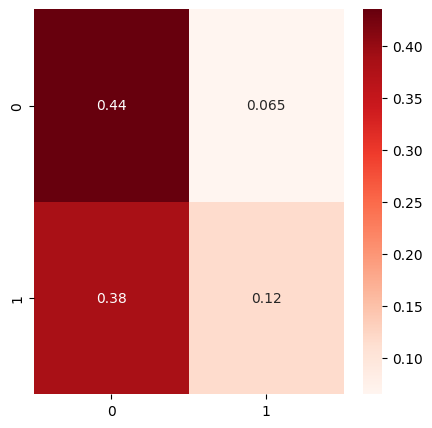

In [175]:
report(y_test, lgbm_best.predict(x_test_selected))

# Результаты

In [176]:
best_models = [rfc_best, xgb_rfc_best, xgb_best, lgbm_best, cb_best]

In [177]:
best_models_cv_metrics = [rfc_best_cv_metrics, xgb_rfc_best_cv_metrics, xgb_best_cv_metrics, lgbm_best_cv_metrics, cb_best_cv_metrics]

In [178]:
def test_results(model, x_test, y_true):
  y_pred = model.predict(x_test)
  round_num = 2
  result_dict = {
      "Accuracy": round(accuracy_score(y_true, y_pred), round_num),
      "AUC": round(roc_auc_score(y_true, y_pred), round_num),
      "Precision": round(precision_score(y_true, y_pred), round_num),
      "Recall": round(recall_score(y_true, y_pred), round_num),
      "F1-score": round(f1_score(y_true, y_pred), round_num),
      "F2-score": round(f2_score(y_true, y_pred), round_num)
  }
  return result_dict

In [179]:
round_num = 2
for metrics in best_models_cv_metrics:
  print("'Accuracy':", round(np.mean(metrics[0]), round_num),"+-",round(np.std(metrics[0]), round_num),",",
        "'AUC':", round(np.mean(metrics[1]), round_num),"+-",round(np.std(metrics[1]), round_num),","
        "'Precision':", round(np.mean(metrics[2]), round_num),"+-",round(np.std(metrics[2]), round_num),","
        "'Recall':", round(np.mean(metrics[3]), round_num),"+-",round(np.std(metrics[3]), round_num),","
        "'F1-score':", round(np.mean(metrics[4]), round_num),"+-",round(np.std(metrics[4]), round_num),","
        "'F2-score':", round(np.mean(metrics[5]), round_num),"+-",round(np.std(metrics[5]), round_num),)

'Accuracy': 0.8 +- 0.04 , 'AUC': 0.88 +- 0.03 ,'Precision': 0.8 +- 0.04 ,'Recall': 0.75 +- 0.07 ,'F1-score': 0.75 +- 0.07 ,'F2-score': 0.76 +- 0.06
'Accuracy': 0.73 +- 0.03 , 'AUC': 0.79 +- 0.03 ,'Precision': 0.72 +- 0.04 ,'Recall': 0.66 +- 0.06 ,'F1-score': 0.66 +- 0.07 ,'F2-score': 0.67 +- 0.04
'Accuracy': 0.73 +- 0.01 , 'AUC': 0.78 +- 0.03 ,'Precision': 0.72 +- 0.04 ,'Recall': 0.67 +- 0.06 ,'F1-score': 0.66 +- 0.08 ,'F2-score': 0.67 +- 0.05
'Accuracy': 0.72 +- 0.02 , 'AUC': 0.8 +- 0.03 ,'Precision': 0.75 +- 0.06 ,'Recall': 0.61 +- 0.05 ,'F1-score': 0.6 +- 0.08 ,'F2-score': 0.63 +- 0.04
'Accuracy': 0.72 +- 0.02 , 'AUC': 0.78 +- 0.04 ,'Precision': 0.71 +- 0.04 ,'Recall': 0.66 +- 0.06 ,'F1-score': 0.65 +- 0.07 ,'F2-score': 0.67 +- 0.04


In [180]:
for model in best_models:
  if model == rfc_best: print(test_results(model, x_test_imp, y_test))
  else: print(test_results(model, x_test_selected, y_test))

{'Accuracy': 0.58, 'AUC': 0.58, 'Precision': 0.68, 'Recall': 0.31, 'F1-score': 0.43, 'F2-score': 0.35}
{'Accuracy': 0.58, 'AUC': 0.58, 'Precision': 0.63, 'Recall': 0.41, 'F1-score': 0.49, 'F2-score': 0.44}
{'Accuracy': 0.6, 'AUC': 0.6, 'Precision': 0.63, 'Recall': 0.46, 'F1-score': 0.53, 'F2-score': 0.49}
{'Accuracy': 0.55, 'AUC': 0.55, 'Precision': 0.64, 'Recall': 0.23, 'F1-score': 0.34, 'F2-score': 0.27}
{'Accuracy': 0.54, 'AUC': 0.54, 'Precision': 0.56, 'Recall': 0.38, 'F1-score': 0.46, 'F2-score': 0.41}


In [181]:
import shap
shap.initjs()

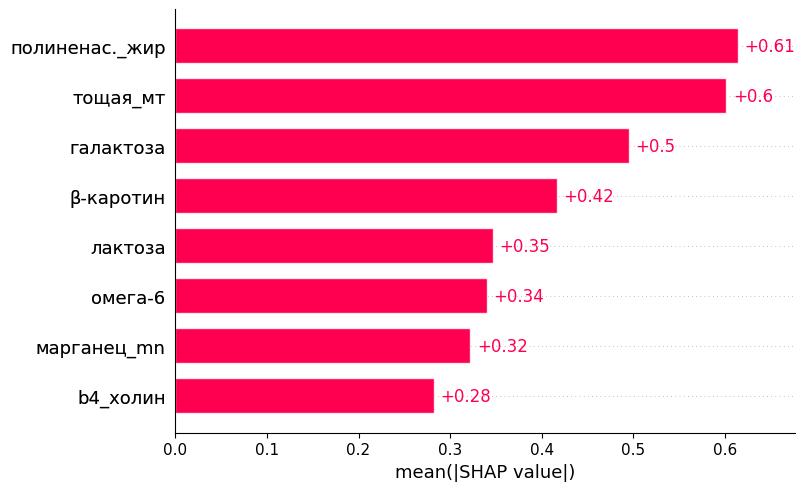

In [182]:
explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer(x_train_selected)
shap.plots.bar(shap_values)